# Diagnostiquez automatiquement des radios thoraciques.

Maintenant que vous avez découvert les CNN et que vous savez entraîner des modèles avec TensorFlow et Keras, vous allez pouvoir utiliser vos nouvelles connaissances pour résoudre un problème plus concret. 

Dans ce notebook, vous allez entraîner un algorithme capable de diagnostiquer automatiquement si notre patient est atteint d'une pneumonie ou non grâce à sa radiographie thoracique. Les données viennent de ce [datasets](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia) de Kaggle.


# Importation des packages

In [1]:
import matplotlib.pyplot as plt

import os
import numpy as np

from sklearn.metrics import accuracy_score, confusion_matrix

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1F1MiX9qQ7ZoafVq68x6ISWgtOsZf7CCi?usp=sharing

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Visualisons nos données !

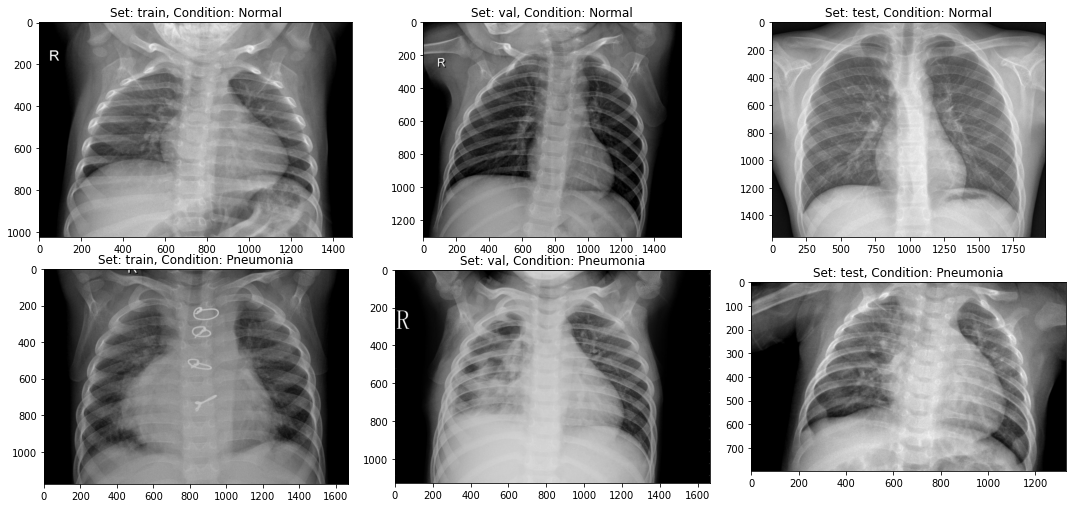

In [3]:
input_path = '/content/drive/MyDrive/chest_xray/'

fig, ax = plt.subplots(2, 3, figsize=(15, 7))
ax = ax.ravel()
plt.tight_layout()

for i, _set in enumerate(['train', 'val', 'test']):
    set_path = input_path+_set
    ax[i].imshow(plt.imread(set_path+'/NORMAL/'+os.listdir(set_path+'/NORMAL') [i]), cmap='gray')
    ax[i].set_title('Set: {}, Condition: Normal'.format(_set))
    ax[i+3].imshow(plt.imread(set_path+'/PNEUMONIA/'+os.listdir(set_path+'/PNEUMONIA') [i]), cmap='gray')
    ax[i+3].set_title('Set: {}, Condition: Pneumonia'.format(_set))

In [4]:
normal_example = os.listdir(f'{input_path}train/NORMAL')[3]
pneumonia_example = os.listdir(f'{input_path}train/PNEUMONIA')[3]

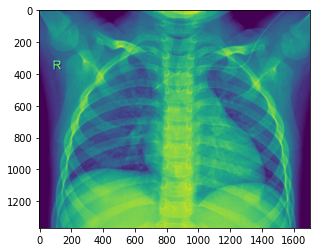

In [5]:
normal_img = plt.imread(f'{input_path}train/NORMAL/{normal_example}')
plt.imshow(normal_img)
plt.show()

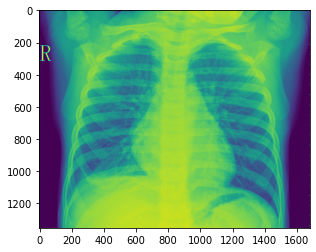

In [6]:
pneumonia_img = plt.imread(f'{input_path}train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)
plt.show()

In [7]:
test_labels = []
for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(input_path + 'test' + cond)):
          if cond=='/NORMAL/':
              label = 0
          elif cond=='/PNEUMONIA/':
              label = 1
          test_labels.append(label)
    
test_labels = np.array(test_labels)

# Initialiser les générateurs 

Utilisez la classe *ImageDataGenerator* pour appliquer des transformation à vos images. C'est cette classe qui est aussi utilisez pour effectuer de la data augmentation.

Appliquez :
- une normalisation /255 ;
- utilisez un zoom de 0.3 ;
- autorisez les invertions vertical.

N'hésitez pas à chercher de l'aide dans la [documentation](https://keras.io/api/preprocessing/image/).

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)

Vous n'allez pas charger directement toutes les images en mémoire pendant l'entraînement. Vous allez utilisez la fonction *flow_from_directory* pour renseigner l'endroit ou se trouve vos images. Les images seront lu batch par batch. 

Utilisez :
- un batch de 32 ;
- une taille d'image de 150x150
- autoriser le mélange des images à chaque époque.

N'hésitez pas à vous aidez de la [documentation](https://keras.io/api/preprocessing/image/).

In [9]:
train_gen = train_datagen.flow_from_directory(
directory='/content/drive/MyDrive/chest_xray/train', 
target_size=(150, 150), 
batch_size=32, 
class_mode='binary', 
shuffle=True)

Found 5225 images belonging to 2 classes.


Faire de même pour le jeu de test et de validation.

In [10]:
val_datagen = ImageDataGenerator(rescale=1./255)    

val_gen = val_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/chest_xray/val', 
    target_size=(150, 150), 
    batch_size=8, 
    class_mode='binary', 
    shuffle=True)

Found 16 images belonging to 2 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale=1./255)    

test_gen = test_datagen.flow_from_directory(
    directory='/content/drive/MyDrive/chest_xray/test', 
    target_size=(150, 150), 
    batch_size=32, 
    class_mode='binary', 
    shuffle=True)

Found 624 images belonging to 2 classes.


# Initialisez votre modèle

In [12]:
# Input layer
inputs = Input(shape=(150, 150, 3))

# First conv block
x = Conv2D(filters=16, kernel_size=(5, 5), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2, 2))(x)

# Second conv block
x = SeparableConv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)

# Third conv block
x = SeparableConv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)


# FC layer
x = Flatten()(x)


# Output layer
output = Dense(units=1, activation='sigmoid')(x)

# Creating model and compiling
model = Model(inputs=inputs, outputs=output)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 146, 146, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 73, 73, 32)        688       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 36, 36, 64)        2400  

# Compilez votre modèle

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Initialisez des Callbacks

In [15]:
# Callbacks
checkpoint = ModelCheckpoint(filepath='best_weights.hdf5', save_best_only=True, save_weights_only=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=1, mode='min')

# Entraînez votre modèle

In [ ]:
# Traning Model
hist = model.fit_generator(
           train_gen, 
           steps_per_epoch=train_gen.samples // 32, 
           epochs=2, 
           validation_freq=1,
           validation_data=val_gen, 
           validation_steps=val_gen.samples // 8,
           callbacks=[checkpoint, lr_reduce])

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
 76/163 [============>.................] - ETA: 20:04 - loss: 0.5320 - accuracy: 0.8042

# Visualisation des performances

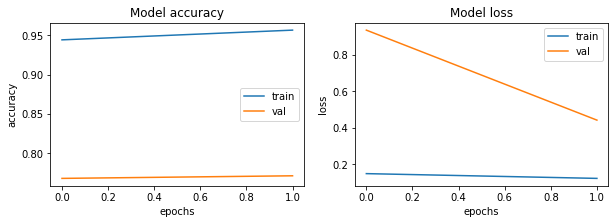

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [ ]:
preds.shape

(624, 1)

In [ ]:
test_labels.shape

(2,)

In [ ]:
preds = model.predict_generator(test_gen)

acc = accuracy_score(test_labels, np.round(preds))*100
cm = confusion_matrix(test_labels, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Accuracy: {}%'.format(acc))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

print('\nTRAIN METRIC ----------------------')
print('Train acc: {}'.format(np.round((hist.history['accuracy'][-1])*100, 2)))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


CONFUSION MATRIX ------------------
[[134 100]
 [222 168]]

TEST METRICS ----------------------
Accuracy: 48.3974358974359%
Precision: 62.68656716417911%
Recall: 43.07692307692308%
F1-score: 51.06382978723405

TRAIN METRIC ----------------------
Train acc: 95.64


# Références :
- https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia